# Google Colab

In [44]:
Google_Colab = True

In [45]:
import os

if Google_Colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/FPL_ML")
else:
    os.chdir("D:\PulpitE\FPL_ML")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports

In [46]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [47]:
# FIXTURES_IN_SAMPLE
FIS = 8

# FIXTURES_FOR_PLAYER - number of gameweeks required
FFP = 15

NEXT_GAMEWEEK = 19

In [48]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Device

In [49]:
# device = torch.device("cuda")
# device = torch.device('mps')
device = torch.device('cpu')

# Getting data and choosing features

In [50]:
df = pd.read_csv('data/final_dataset.csv')

In [51]:
# remembering original dataframes
df_original = df

df_gk_original = df[df["FPL position"] == "GK"]
df_def_original = df[df["FPL position"] == "DEF"]
df_mid_original = df[df["FPL position"] == "MID"]
df_fwd_original = df[df["FPL position"] == "FWD"]

In [52]:
df_original.columns

Index(['Unnamed: 0', 'Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad',
       'Opponent', 'Start', 'Pos', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh',
       'SoT', 'CrdY', 'CrdR', 'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG',
       'xAG', 'SCA', 'GCA', 'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC',
       'Att.1', 'Succ', 'Match Report', 'Name', 'Season', 'WDL', 'GoalsTeams',
       'Team Score', 'Opp Score', 'CS', 'Was Home', 'GW', 'FPL',
       'neutral_name', 'Total Points', 'FPL position', 'Opp rating',
       'ScoreForLast5', 'ScoreAgainstLast5'],
      dtype='object')

In [53]:
info = ["Name", "GW", "FPL position"]
other = ["LSTM"]
features = ["Min", "Gls", "Ast", "Sh", "SoT", "xG", "npxG", "xAG", "SCA", "GCA", "CS", "CrdY", "CrdR", "Opp rating", "Team Score", "Opp Score", "Was Home"]
to_predict = ["FPL"]

In [54]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [55]:
df.shape

(7457, 21)

In [56]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')

# taking onyl players with at least FFP matches in logs
df = grouped.filter(lambda x: len(x) >= FFP)

In [57]:
df.shape

(5771, 21)

In [58]:
df.head(20)

,Name,GW,FPL position,Min,Gls,Ast,Sh,SoT,xG,npxG,...,SCA,GCA,CS,CrdY,CrdR,Opp rating,Team Score,Opp Score,Was Home,FPL
0,Brenden-Aaronson,1,MID,83.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1725.276489,2.0,1.0,1.0,2.0
1,Brenden-Aaronson,2,MID,90.0,0.0,0.0,2.0,0.0,0.1,0.1,...,4.0,0.0,0.0,1.0,0.0,1667.049927,2.0,2.0,0.0,2.0
2,Brenden-Aaronson,3,MID,82.0,1.0,0.0,2.0,2.0,1.0,1.0,...,5.0,1.0,1.0,0.0,0.0,1901.388306,3.0,0.0,1.0,8.0
3,Brenden-Aaronson,4,MID,81.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,1.0,0.0,1783.540161,0.0,1.0,0.0,2.0
4,Brenden-Aaronson,5,MID,75.0,0.0,1.0,1.0,1.0,0.1,0.1,...,4.0,1.0,0.0,0.0,0.0,1688.922485,1.0,1.0,1.0,5.0
5,Brenden-Aaronson,6,MID,90.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1727.113647,2.0,5.0,0.0,2.0
6,Brenden-Aaronson,9,MID,78.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,0.0,0.0,1716.016846,0.0,0.0,1.0,3.0
7,Brenden-Aaronson,10,MID,75.0,0.0,0.0,2.0,0.0,0.1,0.1,...,3.0,1.0,0.0,0.0,0.0,1748.905396,1.0,2.0,0.0,2.0
8,Brenden-Aaronson,11,MID,90.0,0.0,0.0,2.0,1.0,0.1,0.1,...,4.0,0.0,0.0,0.0,0.0,1908.041016,0.0,1.0,1.0,2.0
9,Brenden-Aaronson,12,MID,90.0,0.0,0.0,1.0,0.0,0.1,0.1,...,3.0,0.0,0.0,0.0,0.0,1730.854736,0.0,2.0,0.0,2.0


In [59]:
last_names = df["Name"].unique()

In [60]:
df.columns

Index(['Name', 'GW', 'FPL position', 'Min', 'Gls', 'Ast', 'Sh', 'SoT', 'xG',
       'npxG', 'xAG', 'SCA', 'GCA', 'CS', 'CrdY', 'CrdR', 'Opp rating',
       'Team Score', 'Opp Score', 'Was Home', 'FPL'],
      dtype='object')

In [61]:
df["FPL position"].unique()

array(['MID', 'FWD', 'DEF', 'GK'], dtype=object)

# DF to DataLoader

In [62]:
# gk, def, mid, fwd
df_gk = df[df["FPL position"] == "GK"]
df_def = df[df["FPL position"] == "DEF"]
df_mid = df[df["FPL position"] == "MID"]
df_fwd = df[df["FPL position"] == "FWD"]

In [63]:
df_gk.iloc[0]

Name                Alisson
GW                        1
FPL position             GK
Min                    90.0
Gls                     0.0
Ast                     0.0
Sh                      0.0
SoT                     0.0
xG                      0.0
npxG                    0.0
xAG                     0.0
SCA                     0.0
GCA                     0.0
CS                      0.0
CrdY                    0.0
CrdR                    0.0
Opp rating      1636.164673
Team Score              2.0
Opp Score               2.0
Was Home                0.0
FPL                     2.0
Name: 196, dtype: object

In [64]:
df.shape

(5771, 21)

In [65]:
def init_index_table(df):
    names = df["Name"].unique()
    result_dict = {}
    
    current_index = 0
    player_index = 0
    
    for name in names:
        sample_index = 0
        samples_for_names = df[df["Name"] == name].shape[0] - FIS
        for i in range(samples_for_names):
            result_dict[current_index] = [player_index, sample_index]
            current_index += 1
            sample_index += 1
        player_index += 1
    
    return result_dict

In [66]:
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.index_table = init_index_table(dataframe)
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        length = 0
        for name in self.names:
            length += (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS)
        return length

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = self.index_table[idx]
        name = self.names[player_id]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [67]:
# df[["Name", "FPL position"]].drop_duplicates().head(20)

In [68]:
dataset = PandasDataset(df)
dataset_gk = PandasDataset(df_gk)
dataset_def = PandasDataset(df_def)
dataset_mid = PandasDataset(df_mid)
dataset_fwd = PandasDataset(df_fwd)

In [69]:
# dataset.__getitem__(0)

In [70]:
# dataset_fwd.__getitem__(10)

In [71]:
dataset_gk.__len__()

305

In [72]:
dataset_def.__len__()

1137

In [73]:
dataset_mid.__len__()

1469

In [74]:
dataset_fwd.__len__()

356

In [75]:
batch_size = 16

In [76]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
dataloader_gk = DataLoader(dataset_gk, batch_size=batch_size, shuffle=False)
dataloader_def = DataLoader(dataset_def, batch_size=batch_size, shuffle=False)
dataloader_mid = DataLoader(dataset_mid, batch_size=batch_size, shuffle=False)
dataloader_fwd = DataLoader(dataset_fwd, batch_size=batch_size, shuffle=False)

In [77]:
# next(iter(dataloader_mid))

In [78]:
# next(iter(dataloader))[1]

# LSTM Model

In [79]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

In [80]:
len(dataloader)

205

# Training loops

In [81]:
criterion = nn.MSELoss()

In [82]:
def train_net(net, num_epochs, dataloader, optimizer):
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = torch.flatten(inputs, 1, 2)
            inputs = inputs.unsqueeze(2).to(device)
            targets = targets.to(device)
            # print("INPUTS", inputs.shape)
            # print("TARGETS", targets.shape)
            # print(targets)
            optimizer.zero_grad()
            outputs = net(inputs).flatten().to(device)
            # print("OUTPUTS", outputs.shape)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        loss_history.append(running_loss / len(dataloader))
        if epoch % 5 == 0:
            print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')
    
    return loss_history

In [83]:
def plot_loss_history(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## Training loop - general net

In [84]:
%%time
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_history = train_net(net, 30, dataloader, optimizer)

Epoch 0 Loss: 3.8254568398725697
Epoch 5 Loss: 3.6719020780266787
Epoch 10 Loss: 3.6734810912027593
Epoch 15 Loss: 3.672873644130986
Epoch 20 Loss: 3.671972648399632
Epoch 25 Loss: 3.670287078691692
CPU times: user 13min 1s, sys: 3.06 s, total: 13min 4s
Wall time: 13min 6s


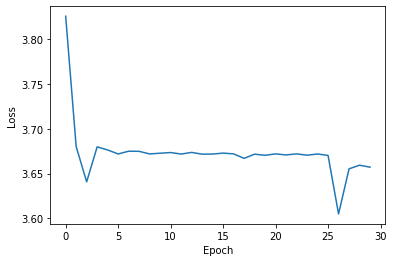

In [85]:
plot_loss_history(loss_history)

## Training loop - goalkeeper net

In [86]:
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [87]:
%%time
optimizer_gk = optim.Adam(net_gk.parameters(), lr=0.01)
loss_history_gk = train_net(net_gk, 5, dataloader_gk, optimizer_gk)

Epoch 0 Loss: 2.034939735382795
CPU times: user 12.3 s, sys: 54.8 ms, total: 12.3 s
Wall time: 12.4 s


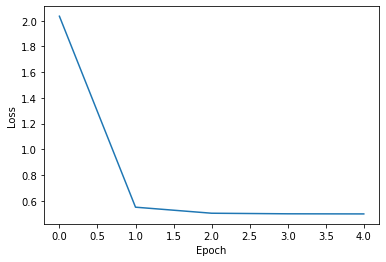

In [88]:
plot_loss_history(loss_history_gk)

## Training loop - defender net

In [89]:
net_def = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [90]:
%%time
optimizer_def = optim.Adam(net_def.parameters(), lr=0.005)
loss_history_def = train_net(net_def, 5, dataloader_def, optimizer_def)

Epoch 0 Loss: 1.9098590057757165
CPU times: user 42.6 s, sys: 160 ms, total: 42.8 s
Wall time: 42.8 s


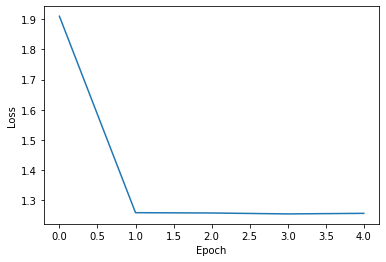

In [91]:
plot_loss_history(loss_history_def)

## Training loop - midfielder net

In [92]:
net_mid = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [93]:
%%time
optimizer_mid = optim.Adam(net_mid.parameters(), lr=0.005)
loss_history_mid = train_net(net_mid, 100, dataloader_mid, optimizer_mid)

Epoch 0 Loss: 5.191942703464757
Epoch 5 Loss: 4.728771607513013
Epoch 10 Loss: 4.725838302270226
Epoch 15 Loss: 4.726539453734523
Epoch 20 Loss: 4.728411800835444
Epoch 25 Loss: 4.7267072278520335
Epoch 30 Loss: 4.7268379077963205
Epoch 35 Loss: 4.728862484512121
Epoch 40 Loss: 4.727018461927123
Epoch 45 Loss: 4.72586067409619
Epoch 50 Loss: 4.727801024265911
Epoch 55 Loss: 4.72617189132649
Epoch 60 Loss: 4.72775409338267
Epoch 65 Loss: 4.728118963863539
Epoch 70 Loss: 4.72818720470304
Epoch 75 Loss: 4.7280812710523605
Epoch 80 Loss: 4.728042306459469
Epoch 85 Loss: 4.728009541397509
Epoch 90 Loss: 4.7278144119874295
Epoch 95 Loss: 4.727738788594371
CPU times: user 17min 17s, sys: 3.67 s, total: 17min 21s
Wall time: 17min 23s


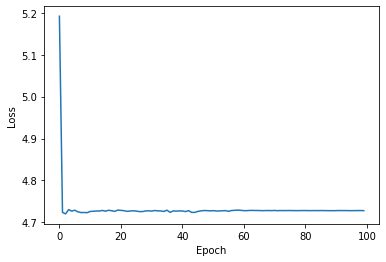

In [94]:
plot_loss_history(loss_history_mid)

## Training loop - forward net

In [95]:
net_fwd = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [ ]:
%%time
optimizer_fwd = optim.Adam(net_fwd.parameters(), lr=0.005)
loss_history_fwd = train_net(net_fwd, 500, dataloader_fwd, optimizer_fwd)

Epoch 0 Loss: 11.747184369875038
Epoch 5 Loss: 8.334213928036068
Epoch 10 Loss: 8.34347107876902
Epoch 15 Loss: 8.341058762177177
Epoch 20 Loss: 8.326221305391062
Epoch 25 Loss: 8.347237897955853
Epoch 30 Loss: 8.336912463540616
Epoch 35 Loss: 8.354683093402697
Epoch 40 Loss: 8.33936059474945
Epoch 45 Loss: 8.323990824429885
Epoch 50 Loss: 8.366993520570839
Epoch 55 Loss: 7.992635533861492
Epoch 60 Loss: 8.253067586732948
Epoch 65 Loss: 8.28649952618972
Epoch 70 Loss: 8.31243963604388
Epoch 75 Loss: 8.359360223231109
Epoch 80 Loss: 8.340004464854365


In [ ]:
plot_loss_history(loss_history_fwd)

# Metrics

In [ ]:
# general model


# Saving models to files

In [ ]:
# general model
torch.save(net.state_dict(), 'models/lstm_general.pt')

# positional models
torch.save(net_gk.state_dict(), 'models/lstm_gk.pt')
torch.save(net_def.state_dict(), 'models/lstm_def.pt')
torch.save(net_mid.state_dict(), 'models/lstm_mid.pt')
torch.save(net_fwd.state_dict(), 'models/lstm_fwd.pt')

# Predictions - general model

In [ ]:
def generate_predictions(dataloader_pos, dataset_pos, net_pos, df_original):
    index = 0
    predictions_pos = []
    for inputs, target in dataloader_pos:
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2).to(device)
        # print("INPUTS", inputs)
        # print(inputs)
        outputs = net_pos(inputs).to(device)
        # print("OUTPUTS", outputs)
        for output in outputs:
            player_id, sample_id = dataset_pos.index_table[index]
            name = dataset_pos.names[player_id]
            df_row = df_original[df_original["Name"] == name].iloc[sample_id + FIS]
            df_gw = df_row["GW"]
            df_opp = df_row["Opponent"]
            points = round(output.item(), 2)
            gw = sample_id + FIS + 1 # wrong
            predictions_pos.append(df_row)
            # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
            index += 1
    
    return predictions_pos

In [ ]:
predictions = generate_predictions(dataloader, dataset, net, df_original)

In [ ]:
prediction_columns = ["DF_GW", "DF_Opponent", "Name", "GW", "Points"]

In [ ]:
# results sorted
pd.DataFrame(predictions, columns=prediction_columns).sort_values(by=["Points"], ascending = False).head(20)

In [ ]:
# # appending results to original df
# for df_gw, df_opp, name, gw, points in predictions:
#     df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [ ]:
df_original.to_csv("data/fpl_fbref_elo_lstm.csv")

# Predictions for each position

## Goalkeepers

In [ ]:
df_gk_original.iloc[0]

In [ ]:
predictions_gk = generate_predictions(dataloader_gk, dataset_gk, net_gk, df_gk_original)

In [ ]:
# results sorted
pd.DataFrame(predictions_gk, columns=prediction_columns).sort_values(by=["Points"], ascending = False).head(20)

## Defenders

In [ ]:
predictions_def = generate_predictions(dataloader_def, dataset_def, net_def, df_def_original)

In [ ]:
# results sorted
pd.DataFrame(predictions_def, columns=prediction_columns).sort_values(by=["Points"], ascending = False).head(20)

## Midfielders

In [ ]:
predictions_mid = generate_predictions(dataloader_mid, dataset_mid, net_mid, df_mid_original)

In [ ]:
# results sorted
pd.DataFrame(predictions_mid, columns=prediction_columns).sort_values(by=["Points"], ascending = False).head(20)

## Forwards

In [ ]:
predictions_fwd = generate_predictions(dataloader_fwd, dataset_fwd, net_fwd, df_fwd_original)

In [ ]:
# results sorted
pd.DataFrame(predictions_fwd, columns=prediction_columns).sort_values(by=["Points"], ascending = False).head(20)